In [95]:
import pandas as pd
import numpy as np
import pysam

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing.label import LabelBinarizer

from utils import get_check_sequences_cagi5, save_base_seqs,\
                  get_seqs_and_inds, load_base_seqs

from matplotlib import pyplot as plt
from crossval import pick_train_chunks, get_breakpoint_df

%matplotlib inline

In [96]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element
0,X,138612669,T,A,-0.17,0.07,0,release_F9
1,X,138612669,T,C,-0.26,0.24,-1,release_F9
2,X,138612669,T,G,0.34,0.05,0,release_F9
3,X,138612670,A,C,0.00,0.00,0,release_F9
4,X,138612670,A,G,0.22,0.20,1,release_F9


In [97]:
test_df = pd.read_csv('data/cagi5_mpra/TestDataset.txt', delimiter='\t')
test_df.head()

,Chrom,Pos,Ref,Alt,Promoter_Enhancer
0,1,109817273,C,A,SORT1
1,1,109817273,C,G,SORT1
2,1,109817274,G,A,SORT1
3,1,109817274,G,C,SORT1
4,1,109817274,G,T,SORT1


In [8]:
print(test_df.groupby(['Promoter_Enhancer'])['Pos'].agg(['min', 'max']))

                         min        max
Promoter_Enhancer                      
F9                 138612621  138612908
GP1BB               19710788   19711173
HBB                  5248252    5248427
HBG1                 5271035    5271309
HNF4A               42984159   42984430
IRF4                  396158     396593
IRF6               209989135  209989736
LDLR                11199922   11200224
MSMB                51548987   51549289
MYC                128413089  128413673
PKLR               155271186  155271656
SORT1              109817273  109817873
TERT-GBM             1295120    1295359
TERT-HEK293T         1295120    1295359
ZFAND3              37775290   37775849


In [9]:
df.groupby(['regulatory_element'])['Pos'].agg(['min', 'max'])

,min,max
regulatory_element,,
release_F9,138612669,138612924
release_GP1BB,19710804,19711139
release_HBB,5248268,5248439
release_HBG1,5271051,5271274
release_HNF4A,42984207,42984444
release_IRF4,396142,396589
release_IRF6,209989199,209989694
release_LDLR,11199906,11200177
release_MSMB,51549083,51549578


In [18]:
print(list(zip(df[df['regulatory_element']=='release_F9']['Pos'].unique(), test_df[test_df['Promoter_Enhancer']=='F9']['Pos'].unique())))
print(test_df[test_df['Promoter_Enhancer']=='F9']['Pos'].unique()[len(df[df['regulatory_element']=='release_F9']['Pos'].unique()):])

[(138612669, 138612621), (138612670, 138612622), (138612671, 138612623), (138612672, 138612624), (138612673, 138612625), (138612674, 138612626), (138612675, 138612627), (138612676, 138612628), (138612677, 138612629), (138612678, 138612630), (138612679, 138612631), (138612680, 138612632), (138612681, 138612633), (138612682, 138612634), (138612683, 138612635), (138612684, 138612636), (138612701, 138612637), (138612702, 138612638), (138612703, 138612639), (138612704, 138612640), (138612705, 138612641), (138612706, 138612642), (138612707, 138612643), (138612708, 138612644), (138612709, 138612645), (138612710, 138612646), (138612711, 138612647), (138612712, 138612648), (138612713, 138612649), (138612714, 138612650), (138612715, 138612651), (138612716, 138612652), (138612765, 138612653), (138612766, 138612654), (138612767, 138612655), (138612768, 138612656), (138612769, 138612657), (138612770, 138612658), (138612771, 138612659), (138612772, 138612660), (138612773, 138612661), (138612774, 138

try to split the datasets into contiguous blocks to get an idea of what's going on, e.g.
(hypothesis would be that each enhancer is split into an equal number of non-overlapping chunks (or alternatively, non-overlapping chunks of equal sizes (equality across enhancers here)). 25% of those chunks are chosen for train

 * F9 test: 138612621-138612668, 138612685-138612700, 138612717-138612732, 138612733-138612764, 138612781-138612876, 138612893-138612908
 * F9 train: 138612669-138612684, 138612701-138612716, 138612765-138612780, 138612877-138612892, 138612909-138612924
 
To fit an F9 model, we want to use leave one (chunk) out cross validation: so train on 5 of 6 chunks, test on the other one

In [99]:
breakpoint_df = get_breakpoint_df(df)

In [100]:
test_breakpoint = get_breakpoint_df(test_df)

In [60]:
np.sum(test_breakpoint['chunk_length']), np.sum(breakpoint_df['chunk_length'])

(4410.0, 1556.0)

In [9]:
sum(test_df.groupby(['Promoter_Enhancer'])['Pos'].nunique())

4410

In [10]:
sum(df.groupby(['regulatory_element'])['Pos'].nunique())

1556

In [61]:
breakpoint_df[breakpoint_df['is_break'].isin(['start', 'end'])]

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,is_break,chunk_length
0,X,138612669,T,A,-0.17,0.07,0,release_F9,start,NaN
47,X,138612684,G,T,-0.02,0.00,0,release_F9,end,16.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,start,NaN
95,X,138612716,G,T,-0.15,0.04,0,release_F9,end,16.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,start,NaN
143,X,138612780,T,G,0.18,0.02,0,release_F9,end,16.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,start,NaN
190,X,138612892,C,T,0.12,0.01,0,release_F9,end,16.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,start,NaN
235,X,138612924,A,G,-0.01,0.00,0,release_F9,end,16.0


In [136]:
print(test_df.groupby(['Promoter_Enhancer'])['Pos'].nunique())
test_breakpoint.groupby(['Promoter_Enhancer'])['chunk_length'].sum()

Promoter_Enhancer
F9              224
GP1BB           290
HBB             144
HBG1            211
HNF4A           224
IRF4            324
IRF6            458
LDLR            239
MSMB            239
MYC             457
PKLR            343
SORT1           457
TERT-GBM        192
TERT-HEK293T    192
ZFAND3          416
Name: Pos, dtype: int64


Promoter_Enhancer
F9              224.0
GP1BB           290.0
HBB             144.0
HBG1            211.0
HNF4A           224.0
IRF4            324.0
IRF6            458.0
LDLR            239.0
MSMB            239.0
MYC             457.0
PKLR            343.0
SORT1           457.0
TERT-GBM        192.0
TERT-HEK293T    192.0
ZFAND3          416.0
Name: chunk_length, dtype: float64

## TODO
* for each enhancer make a bar chart with a fixed height along the y axis and position along the x axis, with the shade given by the dataset membership of the relevant chunk

In [138]:
f9_train = df[df['regulatory_element'] == 'release_F9']
f9_test = test_df[test_df['Promoter_Enhancer'] == 'F9']
f9_train['dataset'] = 'Train'
f9_test['dataset'] = 'Test'

f9_all = pd.concat([f9_train, f9_test], ignore_index=True)

/home/alexh/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alexh/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [146]:
f9_all = f9_all.sort_values(['Pos'])

In [148]:
pos_list = f9_all.groupby(['Pos'])['Pos'].max()
dataset_list = f9_all.groupby(['Pos'])['dataset'].max()

In [164]:
c = ['r' if d == 'Test' else 'b' for d in dataset_list ]

In [168]:
df['regulatory_element'].unique()

array(['release_F9', 'release_GP1BB', 'release_HBB', 'release_HBG1',
       'release_HNF4A', 'release_IRF4', 'release_IRF6', 'release_LDLR',
       'release_MSMB', 'release_MYCrs6983267', 'release_PKLR',
       'release_SORT1', 'release_TERT-GBM', 'release_TERT-HEK293T',
       'release_ZFAND3'], dtype=object)

In [167]:
test_df['Promoter_Enhancer'].unique()

array(['SORT1', 'PKLR', 'IRF6', 'TERT-GBM', 'TERT-HEK293T', 'IRF4',
       'ZFAND3', 'MYC', 'MSMB', 'HBB', 'HBG1', 'LDLR', 'HNF4A', 'GP1BB',
       'F9'], dtype=object)

In [101]:
import math
val_folds = 5
chunk_counts = breakpoint_df[breakpoint_df['is_break']=='end'].groupby(['regulatory_element'])['chunk_length'].agg(['sum', 'count'])
chunk_counts['length_per_chunk'] = chunk_counts['sum'] / chunk_counts['count']
chunk_counts['n_chunk_val'] = chunk_counts['count'] / val_folds
chunk_counts['n_chunk_val'] = np.ceil(chunk_counts['n_chunk_val'])
chunk_counts

,sum,count,length_per_chunk,n_chunk_val
regulatory_element,,,,
release_F9,80.0,5,16.000000,1.0
release_GP1BB,96.0,6,16.000000,2.0
release_HBB,44.0,3,14.666667,1.0
release_HBG1,64.0,4,16.000000,1.0
release_HNF4A,62.0,4,15.500000,1.0
release_IRF4,128.0,8,16.000000,2.0
release_IRF6,144.0,9,16.000000,2.0
release_LDLR,80.0,5,16.000000,1.0
release_MSMB,144.0,9,16.000000,2.0


In [102]:
# label_chunks
breakpoint_df['is_start'] = breakpoint_df['is_break'] == 'start'
breakpoint_df['chunk_id'] = breakpoint_df.groupby(['regulatory_element'])['is_start'].cumsum() - 1

In [76]:
breakpoint_df[breakpoint_df['is_break'].isin(['start', 'end'])]

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,is_break,chunk_length,is_end,chunk_id,is_start
0,X,138612669,T,A,-0.17,0.07,0,release_F9,start,NaN,False,0.0,True
47,X,138612684,G,T,-0.02,0.00,0,release_F9,end,16.0,True,0.0,False
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,start,NaN,False,1.0,True
95,X,138612716,G,T,-0.15,0.04,0,release_F9,end,16.0,True,1.0,False
96,X,138612765,C,A,0.07,0.01,0,release_F9,start,NaN,False,2.0,True
143,X,138612780,T,G,0.18,0.02,0,release_F9,end,16.0,True,2.0,False
144,X,138612877,G,A,-0.09,0.05,0,release_F9,start,NaN,False,3.0,True
190,X,138612892,C,T,0.12,0.01,0,release_F9,end,16.0,True,3.0,False
191,X,138612909,C,A,0.05,0.02,0,release_F9,start,NaN,False,4.0,True
235,X,138612924,A,G,-0.01,0.00,0,release_F9,end,16.0,True,4.0,False


In [107]:
def train_val_split(fold_dict, df, fold=0):
    df['chunk_id'] = df['chunk_id'].astype(int)
    df['is_train'] = True
    for reg_el, fold_chunks in fold_dict.items():
        val_chunks = fold_chunks[fold]
        df.loc[(df['regulatory_element']==reg_el)&(df['chunk_id'].isin(val_chunks)), 'is_train'] = False
    return df

In [106]:
fold_dict

{'release_F9': [[1], [4], [0], [2], [3]],
 'release_GP1BB': [[4, 0], [1], [5], [2], [3]],
 'release_HBB': [[2], [0], [1], [], []],
 'release_HBG1': [[1], [0], [2], [3], []],
 'release_HNF4A': [[3], [1], [2], [0], []],
 'release_IRF4': [[6, 1], [3, 2], [4, 5], [7], [0]],
 'release_IRF6': [[2, 8], [0, 4], [3, 7], [1, 6], [5]],
 'release_LDLR': [[4], [2], [3], [1], [0]],
 'release_MSMB': [[3, 4], [6, 2], [1, 7], [5, 8], [0]],
 'release_MYCrs6983267': [[3, 5], [1, 7], [6, 2], [0, 4], [8]],
 'release_PKLR': [[6, 4], [3, 5], [0, 2], [1], [7]],
 'release_SORT1': [[3, 7], [1, 2], [8, 6], [5, 0], [4]],
 'release_TERT-GBM': [[1], [2], [4], [3], [0]],
 'release_TERT-HEK293T': [[0], [3], [4], [1], [2]],
 'release_ZFAND3': [[2, 4, 0], [4, 9], [9, 7], [7, 1], [1, 6]]}

In [108]:
trainvaldf = train_val_split(fold_dict, breakpoint_df)

In [109]:
val_df = trainvaldf[~trainvaldf['is_train']]
train_df = trainvaldf[trainvaldf['is_train']]

In [105]:
# write each set of chunks as a list with 5 elements corresponding to the folds
fold_dict = pick_train_chunks(chunk_counts)


 SORT1


/home/alexh/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexh/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


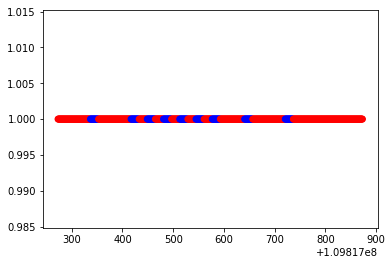


 PKLR


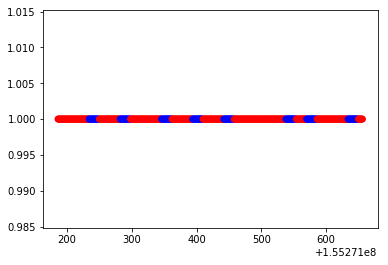


 IRF6


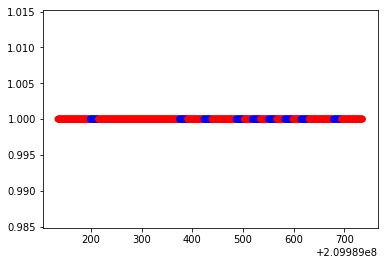


 TERT-GBM


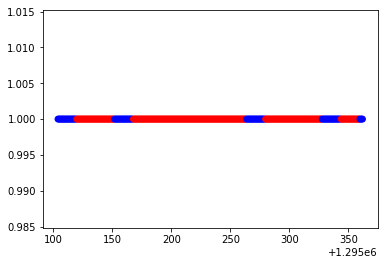


 TERT-HEK293T


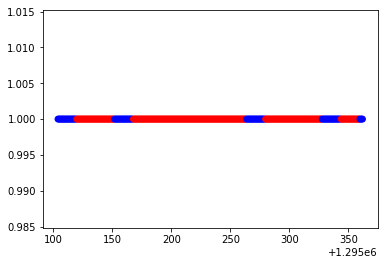


 IRF4


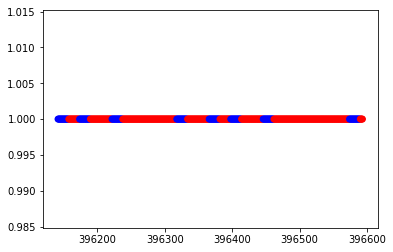


 ZFAND3


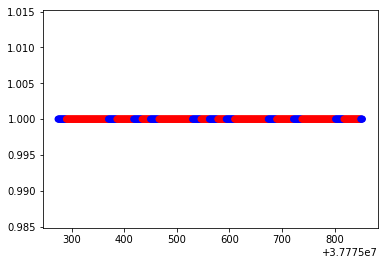


 MYC


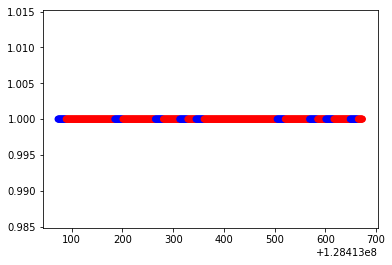


 MSMB


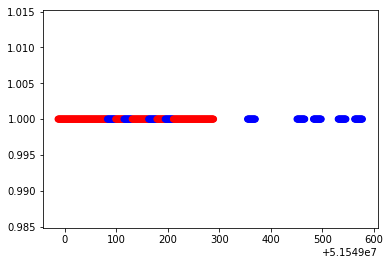


 HBB


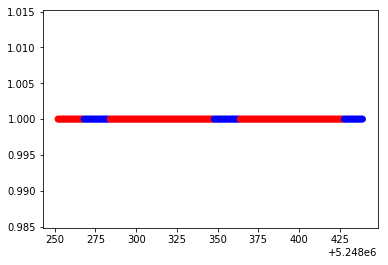


 HBG1


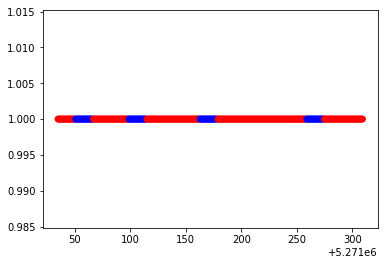


 LDLR


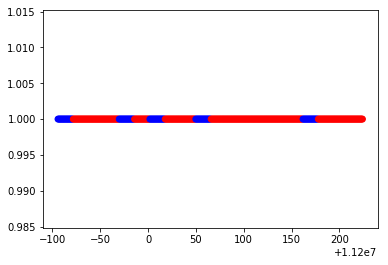


 HNF4A


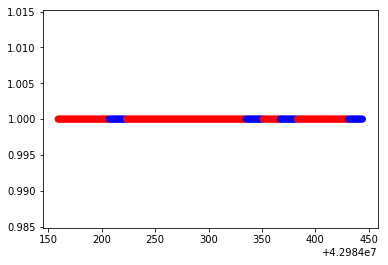


 GP1BB


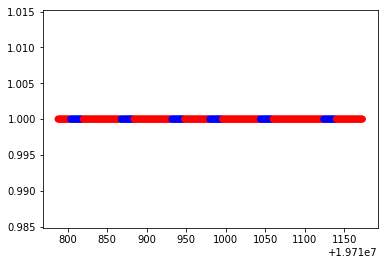


 F9


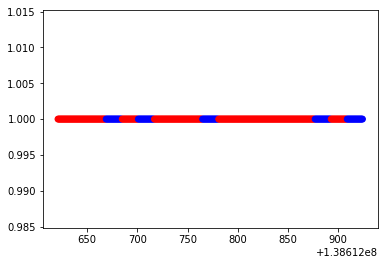

In [170]:
enhancer_list = test_df['Promoter_Enhancer'].unique()
for e in enhancer_list:
    if e == 'MYC':
        e_train = df[df['regulatory_element'] == 'release_MYCrs6983267']
    else:
        e_train = df[df['regulatory_element'] == 'release_{}'.format(e)]
    e_test = test_df[test_df['Promoter_Enhancer'] == e]
    e_train['dataset'] = 'Train'
    e_test['dataset'] = 'Test'

    e_all = pd.concat([e_train, e_test], ignore_index=True)
    pos_list = e_all.groupby(['Pos'])['Pos'].max()
    dataset_list = e_all.groupby(['Pos'])['dataset'].max()
    c = ['r' if d == 'Test' else 'b' for d in dataset_list ]
    print('\n', e)
    fig = plt.figure()
    plt.scatter(pos_list, [1 for x in pos_list],c=c)
    plt.show()

In [172]:
df[df['regulatory_element']=='release_MSMB']

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,is_break
2085,10,51549083,C,A,0.04,0.01,0,release_MSMB,start
2086,10,51549083,C,G,0.13,0.04,0,release_MSMB,no
2087,10,51549083,C,T,-0.02,0.01,0,release_MSMB,no
2088,10,51549084,A,C,-0.03,0.01,0,release_MSMB,no
2089,10,51549084,A,G,0.02,0.01,0,release_MSMB,no
2090,10,51549084,A,T,-0.03,0.03,0,release_MSMB,no
2091,10,51549085,T,A,0.03,0.02,0,release_MSMB,no
2092,10,51549085,T,C,0.00,0.00,0,release_MSMB,no
2093,10,51549085,T,G,0.13,0.04,0,release_MSMB,no
2094,10,51549086,G,A,-0.01,0.00,0,release_MSMB,no


In [173]:
test_df[test_df['Promoter_Enhancer']=='MSMB']

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,is_break
8925,10,51548987,C,A,MSMB,start
8926,10,51548987,C,G,MSMB,no
8927,10,51548987,C,T,MSMB,no
8928,10,51548988,A,C,MSMB,no
8929,10,51548988,A,G,MSMB,no
8930,10,51548988,A,T,MSMB,no
8931,10,51548989,A,C,MSMB,no
8932,10,51548989,A,G,MSMB,no
8933,10,51548989,A,T,MSMB,no
8934,10,51548990,A,C,MSMB,no


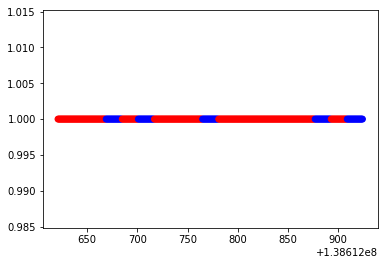

In [165]:
plt.scatter(pos_list, [1 for x in pos_list],c=c)

In [155]:
pos_list[100:150]

Pos
138612721    138612721
138612722    138612722
138612723    138612723
138612724    138612724
138612725    138612725
138612726    138612726
138612727    138612727
138612728    138612728
138612729    138612729
138612730    138612730
138612731    138612731
138612732    138612732
138612733    138612733
138612734    138612734
138612735    138612735
138612736    138612736
138612737    138612737
138612738    138612738
138612739    138612739
138612740    138612740
138612741    138612741
138612742    138612742
138612743    138612743
138612744    138612744
138612745    138612745
138612746    138612746
138612747    138612747
138612748    138612748
138612749    138612749
138612750    138612750
138612751    138612751
138612752    138612752
138612753    138612753
138612754    138612754
138612755    138612755
138612756    138612756
138612757    138612757
138612758    138612758
138612759    138612759
138612760    138612760
138612761    138612761
138612762    138612762
138612763    138612763
1386127

In [105]:
test_breakpoint[test_breakpoint['Promoter_Enhancer'] == 'TERT-GBM']

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,is_break,chunk_length
4192,5,1295120,G,A,TERT-GBM,start,NaN
4384,5,1295168,C,A,TERT-GBM,start,NaN
4960,5,1295280,G,A,TERT-GBM,start,NaN
5248,5,1295344,G,A,TERT-GBM,start,NaN


In [116]:
test_df[test_df['Promoter_Enhancer'] == 'TERT-GBM'].loc[4380:4385]

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,is_break
4380,5,1295151,C,T,TERT-GBM,no
4384,5,1295168,C,A,TERT-GBM,start
4385,5,1295168,C,G,TERT-GBM,no


In [121]:
test_df.sort_values(['Promoter_Enhancer', 'Pos'])

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,is_break
12965,X,138612621,C,A,F9,start
12966,X,138612621,C,G,F9,no
12967,X,138612621,C,T,F9,no
12968,X,138612622,G,A,F9,no
12969,X,138612622,G,C,F9,no
12970,X,138612622,G,T,F9,no
12971,X,138612623,T,A,F9,no
12972,X,138612623,T,C,F9,no
12973,X,138612623,T,G,F9,no
12974,X,138612624,C,A,F9,no


In [118]:
test_df.loc[4370:4385]

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,is_break
4370,5,1295149,C,G,TERT-HEK293T,no
4371,5,1295149,C,T,TERT-HEK293T,no
4372,5,1295150,G,A,TERT-GBM,no
4373,5,1295150,G,C,TERT-GBM,no
4374,5,1295150,G,T,TERT-GBM,no
4375,5,1295150,G,A,TERT-HEK293T,no
4376,5,1295150,G,C,TERT-HEK293T,no
4377,5,1295150,G,T,TERT-HEK293T,no
4378,5,1295151,C,A,TERT-GBM,no
4379,5,1295151,C,G,TERT-GBM,no


/home/alexh/py3env/lib/python3.4/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alexh/py3env/lib/python3.4/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([ 29.,  19.,  19.,  11.,   5.,   5.,   2.,   1.,   1.,   1.]),
 array([   0. ,   17.6,   35.2,   52.8,   70.4,   88. ,  105.6,  123.2,
         140.8,  158.4,  176. ]),
 <a list of 10 Patch objects>)

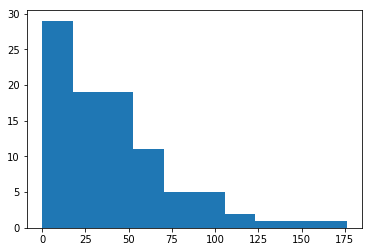

In [82]:
plt.hist(test_breakpoint['chunk_length'], range=(0,176))

/home/alexh/py3env/lib/python3.4/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alexh/py3env/lib/python3.4/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0. ,   17.6,   35.2,   52.8,   70.4,   88. ,  105.6,  123.2,
         140.8,  158.4,  176. ]),
 <a list of 10 Patch objects>)

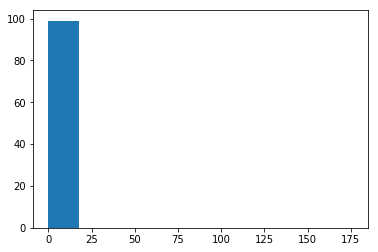

In [83]:
plt.hist(breakpoint_df['chunk_length'], range=(0,176))

In [4]:
refs, alts, inds = get_seqs_and_inds(df)

In [5]:
df['ref_sequence'] = refs
df['alt_sequence'] = alts
df['snp_index'] = inds
df['Refcheck'] = df.apply(lambda row: row['ref_sequence'][row['snp_index']], axis=1)
df['Altcheck'] = df.apply(lambda row: row['alt_sequence'][row['snp_index']], axis=1)
import re
df['base_element'] = df.apply(lambda row: row['regulatory_element'][8:], axis=1)
df['base_element'] = df.apply(lambda row: 'TERT' if re.match('TERT', row['base_element']) else row['base_element'], axis=1)

In [49]:
import numpy as np

refp = np.load('data/cagi5_mpra/deepsea_ref_preds.npy')
altp = np.load('data/cagi5_mpra/deepsea_alt_preds.npy')

In [78]:
df['sigdiff'] = df.apply(lambda row: int(row['class'] ==-1 or row['class']==1), axis=1)
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,ref_sequence,alt_sequence,snp_index,Refcheck,Altcheck,base_element,cv_prediction,majority,sigdiff
0,X,138612669,T,A,-0.17,0.07,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCA...,45,T,A,F9,1.0,0.0,0
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCC...,45,T,C,F9,1.0,0.0,1
2,X,138612669,T,G,0.34,0.05,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCG...,45,T,G,F9,1.0,0.0,0
3,X,138612670,A,C,0.00,0.00,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,46,A,C,F9,1.0,0.0,0
4,X,138612670,A,G,0.22,0.20,1,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,46,A,G,F9,1.0,0.0,1


In [112]:
from utils import snp_feats_from_preds

xdiff = snp_feats_from_preds(refp, altp, feattypes=['diff'])

In [113]:
target_col = 'class'

train_df = df[df['base_element']!='TERT']
val_df = df[df['base_element']=='TERT']

X_train = xdiff[train_df.index.values]
y_train = train_df[target_col]

X_val = xdiff[val_df.index.values]
y_val = val_df[target_col]

In [114]:
import xgboost as xgb

xg = xgb.XGBClassifier()

In [119]:
sample_weight = compute_sample_weight('balanced', y_train)
xg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-merror:0.203765	validation_1-merror:0.3375
[1]	validation_0-merror:0.199765	validation_1-merror:0.2975
[2]	validation_0-merror:0.201882	validation_1-merror:0.295
[3]	validation_0-merror:0.200471	validation_1-merror:0.28
[4]	validation_0-merror:0.195529	validation_1-merror:0.2825
[5]	validation_0-merror:0.195765	validation_1-merror:0.265
[6]	validation_0-merror:0.196471	validation_1-merror:0.25
[7]	validation_0-merror:0.195765	validation_1-merror:0.2525
[8]	validation_0-merror:0.196471	validation_1-merror:0.2475
[9]	validation_0-merror:0.195529	validation_1-merror:0.2425
[10]	validation_0-merror:0.196235	validation_1-merror:0.245
[11]	validation_0-merror:0.193647	validation_1-merror:0.23
[12]	validation_0-merror:0.193412	validation_1-merror:0.23
[13]	validation_0-merror:0.192	validation_1-merror:0.21
[14]	validation_0-merror:0.192	validation_1-merror:0.195
[15]	validation_0-merror:0.191059	validation_1-merror:0.195
[16]	validation_0-merror:0.190588	validation_1-merror:0

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [116]:
binarizer = LabelBinarizer()
binarizer.fit_transform(y_val)

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

## TODO
 * to make sure I know what's going on: explicitly set up one vs rest training, validation (by creating is_repressive, is_activating, is_sigdiff classes on df - all of these are of interest as classifications)
 * test non-abs diff features
 * look up reasons for favouring one v rest vs multinomial multiclass classifier

In [120]:
# seems like predicting negs is possible, predicting positives is harder
print(roc_auc_score(ybin, binarizer.transform(xg.predict(X_val)), average=None),
      roc_auc_score(ybin, binarizer.transform(np.zeros(y_val.shape))))

[ 0.49717514  0.49695122  0.5       ] 0.5


In [118]:
binarizer.__dict__

{'classes_': array([-1,  0,  1]),
 'neg_label': 0,
 'pos_label': 1,
 'sparse_input_': False,
 'sparse_output': False,
 'y_type_': 'multiclass'}

In [88]:
print(roc_auc_score(y_val, xg.predict(X_val)), average_precision_score(y_val, xg.predict(X_val)))
print(accuracy_score(y_val, xg.predict(X_val)))
print(accuracy_score(y_val, np.zeros(y_val.shape)))
print(roc_auc_score(y_val, np.zeros(y_val.shape)))

0.619918699187 0.431287878788
0.75
0.82
0.5


In [75]:
np.max(X_val)

0.39666417241096497

In [12]:
from crossval import cvpreds_df
from models import DeepSeaSNP

cvdf = cvpreds_df(df, DeepSeaSNP, model_kwargs={'classifier': 'xgb',
                                                'feattypes':['diff'],
                                                'verbose': False, 
                                                'classifier_kwargs': {'reg_lambda': 10,
                                                                      'booster': 'gbtree'}})

In [11]:
from sklearn.metrics import accuracy_score

binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf['class'])
print(roc_auc_score(ybin, binarizer.transform(cvdf['cv_prediction']), average=None))

# lr diff: 0.6135, 0.542, 0.6000
# lr absdiff: 0.571, 0.587, 0.517
# gblinear diff: 0.612, 0.57, 0.58
binarizer.classes_

[ 0.61247667  0.57070927  0.58252753]


array([-1,  0,  1])

In [19]:
binarizer = LabelBinarizer()
ybin = binarizer.fit_transform(cvdf[cvdf['base_element']=='TERT']['class'])
print(roc_auc_score(ybin, binarizer.transform(cvdf[cvdf['base_element']=='TERT']['cv_prediction']), average=None))

[ 0.73188406  0.71104336  0.59934183]


In [44]:
cvdf['majority'] = 0.
accuracy_score(cvdf['class'], cvdf['majority'])

0.76129032258064511

In [41]:
cvdf.groupby(['class']).count()

,#Chrom,Pos,Ref,Alt,Value,Confidence,regulatory_element,ref_sequence,alt_sequence,snp_index,Refcheck,Altcheck,base_element,cv_prediction
class,,,,,,,,,,,,,,
-1,736,736,736,736,736,736,736,736,736,736,736,736,736,736
0,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540
1,374,374,374,374,374,374,374,374,374,374,374,374,374,374


In [40]:
cvdf.groupby(['cv_prediction']).count()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,ref_sequence,alt_sequence,snp_index,Refcheck,Altcheck,base_element
cv_prediction,,,,,,,,,,,,,,
-1.0,644,644,644,644,644,644,644,644,644,644,644,644,644,644
0.0,3396,3396,3396,3396,3396,3396,3396,3396,3396,3396,3396,3396,3396,3396
1.0,610,610,610,610,610,610,610,610,610,610,610,610,610,610


In [10]:
from utils import snpfeats_from_df, seqfeats_from_df
# absdiff = snpfeats_from_df(df, 1000)
refp, altp = seqfeats_from_df(df, use_gpu=False, seqlen=1000)

<class 'list'>
<class 'list'>


In [14]:
import numpy as np
np.save('data/cagi5_mpra/deepsea_ref_preds.npy', refp)
np.save('data/cagi5_mpra/deepsea_alt_preds.npy', altp)

In [7]:
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,ref_sequence,alt_sequence,snp_index,Refcheck,Altcheck
0,X,138612669,T,A,-0.17,0.07,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCA...,45,T,A
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCC...,45,T,C
2,X,138612669,T,G,0.34,0.05,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCG...,45,T,G
3,X,138612670,A,C,0.00,0.00,0,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,46,A,C
4,X,138612670,A,G,0.22,0.20,1,release_F9,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCT...,46,A,G


## TODO
 * setup crossval (keep the TERTs together)
 * data exploration: how many of each class are there etc.
 * write a generate feats script that will allow me to run on gpu and save b.c. otherwise it's too slow
   (although now I should be able to use one of my newly trained models on the login node gpu without any trouble)

In [3]:
df[df['Pos'].isin([128413071, 128413072, 128413073, 128413074, 128413075])]

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element
2517,8,128413073,C,A,0.09,0.00,0,release_MYCrs6983267
2518,8,128413073,C,T,-0.03,0.00,0,release_MYCrs6983267
2519,8,128413074,C,A,0.04,0.01,0,release_MYCrs6983267
2520,8,128413074,C,G,-0.01,0.00,0,release_MYCrs6983267
2521,8,128413074,C,T,-0.49,0.13,-1,release_MYCrs6983267
2522,8,128413075,T,A,0.00,0.00,0,release_MYCrs6983267
2523,8,128413075,T,C,-0.06,0.01,0,release_MYCrs6983267
2524,8,128413075,T,G,-0.21,0.04,0,release_MYCrs6983267


In [16]:
with pysam.Fastafile(fasta_file) as genome:
  d0 = genome.fetch('chr8', 128413072, 128413073)
  d1 = genome.fetch('chr8', 128413073, 128413074)
  d2 = genome.fetch('chr8', 128413074, 128413075)
  print(d0, d1, d2)

G C T


In [6]:
df[df['Pos'].isin([396142])]

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element
1034,6,396142,T,A,-0.02,0.00,0,release_IRF4
1035,6,396142,T,C,0.02,0.00,0,release_IRF4
1036,6,396142,T,G,0.15,0.07,0,release_IRF4


In [5]:
with pysam.Fastafile(fasta_file) as genome:
  d0 = genome.fetch('chr6', 396141, 396142)
  d1 = genome.fetch('chr6', 396142, 396143)
  print(d0, d1)

G G


In [3]:
ref, alt, inds = get_sequences_cagi5(df)

G does not match row ref T, position 396142 chr 6 in release_IRF4 CRE
0
G does not match row ref T, position 396142 chr 6 in release_IRF4 CRE
0
G does not match row ref T, position 396142 chr 6 in release_IRF4 CRE
0
G does not match row ref C, position 128413073 chr 8 in release_MYCrs6983267 CRE
0
G does not match row ref C, position 128413073 chr 8 in release_MYCrs6983267 CRE
0
T does not match row ref C, position 37775274 chr 6 in release_ZFAND3 CRE
0
T does not match row ref C, position 37775274 chr 6 in release_ZFAND3 CRE
0


In [7]:
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element
0,X,138612669,T,A,-0.17,0.07,0,release_F9
1,X,138612669,T,C,-0.26,0.24,-1,release_F9
2,X,138612669,T,G,0.34,0.05,0,release_F9
3,X,138612670,A,C,0.00,0.00,0,release_F9
4,X,138612670,A,G,0.22,0.20,1,release_F9


In [19]:
df.groupby(['Ref'])['regulatory_element'].max()

Ref
A    release_ZFAND3
C    release_ZFAND3
G    release_ZFAND3
T    release_ZFAND3
Name: regulatory_element, dtype: object

In [15]:
from constants import LOCS

print(len(set(ref)), len(LOCS)) # n.b. this discrepancy is due to the 3 locations where the stated ref sequence does not match the genome

17 14


In [9]:
for i in [0, 123, 457, 999]:
  print(ref[i][inds[i]], alt[i][inds[i]], df.loc[i][['Ref', 'Alt']].values)

T A ['T' 'A']
T A ['T' 'A']
C T ['C' 'T']
G C ['G' 'C']


two options with things that don't match reference:
 * just predict 0
 * just use what they say as the ref

In [59]:
fasta_file = 'data/remote_data/hg19.genome.fa'
f9_start = 138612624
f9_end = 138612924
pos = 138612670
rel_pos = pos-f9_start-1
with pysam.Fastafile(fasta_file) as genome:
  t = genome.fetch('chrX', 138612668, 138612669)
  a = genome.fetch('chrX', 138612669, 138612670)
  print(t,a)
  dnastr = genome.fetch('chrX', f9_start, f9_end)
print(dnastr[rel_pos])

T A
A


In [52]:
seqstarts = df.groupby(['regulatory_element'])['Pos'].min()
seqends = df.groupby(['regulatory_element'])['Pos'].max()
print(seqstarts)
print(seqends)

regulatory_element
release_F9              138612669
release_GP1BB            19710804
release_HBB               5248268
release_HBG1              5271051
release_HNF4A            42984207
release_IRF4               396142
release_IRF6            209989199
release_LDLR             11199906
release_MSMB             51549083
release_MYCrs6983267    128413073
release_PKLR            155271234
release_SORT1           109817337
release_TERT-GBM          1295104
release_TERT-HEK293T      1295104
release_ZFAND3           37775274
Name: Pos, dtype: int64
regulatory_element
release_F9              138612924
release_GP1BB            19711139
release_HBB               5248439
release_HBG1              5271274
release_HNF4A            42984444
release_IRF4               396589
release_IRF6            209989694
release_LDLR             11200177
release_MSMB             51549578
release_MYCrs6983267    128413664
release_PKLR            155271649
release_SORT1           109817736
release_TERT-GBM    

In [46]:
seqlengths = {}
for k, v in seqstarts.iteritems():
  seqlengths[k] = seqends.loc[k] - v
seqlengths

{'release_F9': 255,
 'release_GP1BB': 335,
 'release_HBB': 171,
 'release_HBG1': 223,
 'release_HNF4A': 237,
 'release_IRF4': 447,
 'release_IRF6': 495,
 'release_LDLR': 271,
 'release_MSMB': 495,
 'release_MYCrs6983267': 591,
 'release_PKLR': 415,
 'release_SORT1': 399,
 'release_TERT-GBM': 258,
 'release_TERT-HEK293T': 258,
 'release_ZFAND3': 579}

## TODO 
* look up evaluation metrics for multiclass classification (is there a binary metric like the one below)

a multiple linear regression model of log2(RNA) ~ log2(DNA) + N + offset (were RNA and DNA are counts observed for all n tags, N is a binary matrix associating n tags to m sequence variants and offset is the models' offset normalizing total DNA to RNA counts) was used to assign sequence effects. From the fit, m coefficients (corresponding to the columns of matrix N) were obtained and assigned as the effects of each sequence variant (SNV). A confidence score was derived by capping the p-value of the multiple linear regression at 10-50 and scaling the log10-transformed value between 0 and 1 (i.e. 1 corresponding to a p-value of ≤10-50, 0.5 of 10-25, 0 to a p-value of 1). We deemed a confidence score greater or equal to 0.1 (p-value of 10-5) indicates that the SNV "has an expression effect" while <0.1 means "has no expression effect".

So we want to predict confidence (regression bounded between 0 and 1), a categorical effect given by:
 -1 if value < 0 and confidence > 0.1,
 0  if confidence < 0.1
 1 if value > 0 and confidence > 0.1,
and probability values for the assigned classes (this could come from predict_proba for example)

prediction is categorical, but data isn't ... Direction - Estimated variant effect from the experimental data. Categorical prediction of repressive. (submitted value -1)/activating (submit a value 1)/no effect (submit a value 0), i.e. allele effect is increasing reporter expression (activating), reducing expression (repressive), or not significantly different from zero (confidence score below 0.1).

Two approaches to consider:
(i) directly training a classifier on the class labels
(ii) training to predict value, confidence (regressors), and using these to compute a prediction for the class

You can probably calculate $\Pi_{y = \hat{y}}(p(\hat{y}))\times\Pi_{y\neq\hat{y}}(1-p(\hat{y}))$, which is an approximation to the full categorical cross entropy i suppose

In [13]:
def get_class(row):
  val = row['Value']
  conf = row['Confidence']
  if conf < 0.1:
    return 0
  elif val < 0:
    return -1
  elif val > 0:
    return 1

In [15]:
classes = f9_df.apply(lambda row: get_class(row), axis=1)

In [16]:
classes

0      0
1     -1
2      0
3      0
4      1
5      0
6      0
7      1
8      0
9      0
10     0
11     0
12     0
13     0
14     1
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25    -1
26     0
27     0
28     0
29     0
      ..
206    0
207    0
208    0
209    1
210    0
211    0
212    0
213    1
214    0
215    0
216    1
217    0
218    0
219    1
220    0
221    0
222    0
223    0
224    0
225    0
226    0
227    0
228    0
229    0
230    0
231    0
232    0
233    0
234    0
235    0
Length: 236, dtype: int64